# Problem $3$: Testing and training the transformer model

In this file we test and train the transformer model we implemented in problem $2$. 

In [23]:
from layers import *
from neural_network import NeuralNetwork
from utils import onehot
import numpy as np
import matplotlib.pyplot as plt
from data_generators import *
from training_utils import *

### $3.1$: Testing if the layers are implemented correctly
Here, we check that the functions implemented return matrices of the correct dimensions, and that the functions run. 

In [31]:
#We choose some arbitrary values for the dimensions
b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20

#Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

#initialize the layers
feed_forward = FeedForward(d,p)
attention = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m)
softmax = Softmax()


#a manual forward pass
X = onehot(x, m)
z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 



#check the shapes
assert X.shape == (b,m,n), f"X.shape={X.shape}, expected {(b,m,n)}"
assert z0.shape == (b,d,n), f"z0.shape={z0.shape}, expected {(b,d,n)}"
assert z1.shape == (b,d,n), f"z1.shape={z1.shape}, expected {(b,d,n)}"
assert z2.shape == (b,d,n), f"z2.shape={z2.shape}, expected {(b,d,n)}"
assert z3.shape == (b,m,n), f"z3.shape={z3.shape}, expected {(b,m,n)}"
assert Z.shape == (b,m,n), f"Z.shape={Z.shape}, expected {(b,m,n)}"

#is X one-hot?
assert X.sum() == b*n, f"X.sum()={X.sum()}, expected {b*n}"


assert np.allclose(Z.sum(axis=1), 1), f"Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}"
assert np.abs(Z.sum() - b*n) < 1e-5, f"Z.sum()={Z.sum()}, expected {b*n}"
assert np.all(Z>=0), f"Z={Z}, expected all entries to be non-negative"

"""
Passes all checks
"""

'\nPasses all checks\n'

Now that we know all matrices are of correct dimension, we check that we can do a forward and backward pass, and that $\texttt{step\_gd()}$ works. In essence, checking if the system learns. We print $L$ for every $1000$ iteration, to check that the loss function continues to decrease. 

In [32]:
#test the forward pass
n_y = n_max - 1
x = np.random.randint(0, m, (b,n_max))
X = onehot(x, m)

#we test with a y that is shorter than the maximum length
y = np.random.randint(0, m, (b,n_y))

#initialize a neural network based on the layers above
network = NeuralNetwork([embed_pos, feed_forward, attention, un_embed, softmax])
#and a loss function
loss = CrossEntropy()

N = 10000
#do a forward pass
for i in range(N):
    Z = network.forward(X)

    #compute the loss
    L = loss.forward(Z, y)
    if not (i%(N//10)):
        print(f"L number {i} is {L:.7f}")

    #get the derivative of the loss wrt Z
    grad_Z = loss.backward()

    #and perform a backward pass
    _ = network.backward(grad_Z)

    #and and do a gradient descent step
    _ = network.step_gd(0.01)

L number 0 is 2.1052545
L number 1000 is 0.2223239
L number 2000 is 0.0537405
L number 3000 is 0.0443407
L number 4000 is 0.0418113
L number 5000 is 0.0407200
L number 6000 is 0.0401341
L number 7000 is 0.0397764
L number 8000 is 0.0395385
L number 9000 is 0.0393700


### 3.2: Testing of our trainingfunction 

Here we are testing our training algorithm $\texttt{training}$ with a sorting problem where we try to sort a list of 5 numbers ranging from 0 to 9. We plot the Loss function Cross Entropy as a function of iteration step, and assign the y-axis a logarithmic scale. 

In [4]:
"""
Initialize the training data.
"""
nBatches = 10
batchSize = 250
r = 5
n_max = 2*r-1
m = 2
n_iter = 300

d = 10
k = 5
p = 15

"""
Create the neural network layers
"""
feed_forward_bin1 = FeedForward(d,p)
feed_forward_bin2 = FeedForward(d,p)

attention_bin1 = Attention(d,k)
attention_bin2 = Attention(d,k)

embed_pos_bin= EmbedPosition(n_max,m,d)
un_embed_bin = LinearLayer(d,m)
softmax_bin = Softmax()

"""
Initialize a nerual network with a loss function
"""
network_bin = NeuralNetwork([embed_pos_bin, feed_forward_bin1, attention_bin1, feed_forward_bin2, attention_bin2, un_embed_bin, softmax_bin])
loss_bin = CrossEntropy()

"""
Generate test data
"""
dataSet_bin = get_train_test_sorting(5, m, batchSize,nBatches, 1)
dataSet_bin_Training = [dataSet_bin['x_train'], dataSet_bin['y_train']]

"""
Train the neural network
"""
L = training(network_bin, loss_bin, dataSet_bin_Training, n_iter, m, alpha = 0.001)

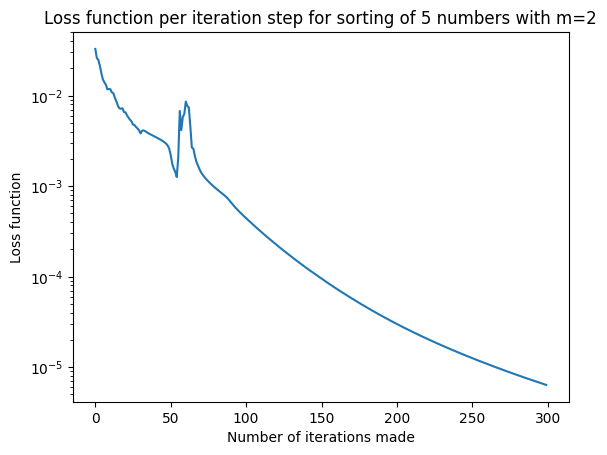

The last loss function value: 0.000006

Percentage of valid sortings with m=2:  100.0 %


In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
ax.set_yscale('log')
ax.set_title(f'Loss function per iteration step for sorting of 5 numbers with m={m}')
ax.set_xlabel('Number of iterations made')
ax.set_ylabel('Loss function')
plt.show()

x_test_bin, y_test_bin = dataSet_bin['x_test'][0], dataSet_bin["y_test"][0]
for i in range(5):
    z = np.argmax(network_bin.forward(onehot(x_test_bin,m)), axis = 1)
    x_test_bin = np.append(x_test_bin, z[:,-1:], axis = 1)
nn_solutions_bin = x_test_bin[:,5:]
t = 0
for idx in range(np.shape(nn_solutions_bin)[0]):
    if (np.array_equal(nn_solutions_bin[idx],y_test_bin[idx])):
        t+=1

print(f"The last loss function value: {L[-1]:.6f}\n")
print("Percentage of valid sortings with m=2: ", t/np.shape(x_test_bin)[0]*100, "%")

### A sorting problem that is a bit more challenging

As we could see, sorting 5 numbers ranging from 0 to 1 wasn't really a challenge for our code. So here we try and sort 7 numbers ranging from 0 to 4. Since we've increased $m$, we also increase the other parameters, such that we have $ d = 20, k = 10 and p=25$

In [22]:
nBatches = 10
batchSize = 250
length = 7
n_max = length*2-1
m = 5
n_iter = 300
d = 20
k = 10
p = 25

feed_forward1D = FeedForward(d,p)
attention1D = Attention(d,k)
feed_forward2D = FeedForward(d,p)
attention2D = Attention(d,k)
embed_pos1D = EmbedPosition(n_max,m,d)
un_embed1D = LinearLayer(d,m)
softmax1D = Softmax()
network1D = NeuralNetwork([embed_pos1D, feed_forward1D, attention1D, feed_forward2D, attention2D, un_embed1D, softmax1D])
loss1D = CrossEntropy()
dataAndTrain1D = get_train_test_sorting(length, m, batchSize, nBatches, n_batches_test=1)
dataSet1D = [dataAndTrain1D["x_train"], dataAndTrain1D["y_train"]]
L = training(network1D, loss1D, dataSet1D, n_iter, m, alpha = 0.001)

fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
ax.set_yscale('log')
ax.set_title(f'Loss function per iteration step for sorting of {length} numbers with m={m}')
ax.set_xlabel('Number of iterations made')
ax.set_ylabel('Loss function')
plt.show()


y = np.copy(dataAndTrain1D["x_test"][0])
for i in range(length):
    z = np.argmax(network1D.forward(onehot(y,m)), axis = 1)
    y = np.append(y, z[:,-1:], axis = 1)
t = 0
s = np.copy(dataAndTrain1D["y_test"][0])
y = y[:,length:]
for i in range(np.shape(s)[0]):
    if (np.array_equal(y[i],s[i])):
        t+=1

print(f"The last loss function value: {L[-1]:.6f}\n")
print(f"Percentage of valid sortings with m={m}: ", t/np.shape(y)[0]*100, "%")

KeyboardInterrupt: 

### $3.4$: Addition of two digit integers

The following code block attempts to train the transformer model to add numbers. Even though our transformer model managed to sort numbers with good precision, it does not handle addition pretty well. By testing many different combinations of dimensions, number of samples and batches, and so forth, the success rate varies everywhere from around $0.01\%$ to $45\%$. The loss function usually stabilizes somewhere between $15$ and $18$, but has managed to decrease to about $0.5$. Thus, is seems like the problem originates from the implementation of the transformer model, as opposed failed calculation of success rate. Since the model handles sorting so well, we believe that there may be a slicing error somewhere that does not appear for sorting numbers, but creates a problem once trying to add numbers. After spending a lot of time trying to figure out what the problem is, we still haven't managed to find out where the problem originates. As a result, our attempt in the following code block is not very successful.

In [10]:
# Initializing dimensions
n_max = 6
m = 10
n_iter = 150
length = 3

d = 30
k = 20
p = 40

samples_per_batch = 250
n_batches_train = 20
n_batches_test = 4

# Creating the layers 
feed_forward1_add = FeedForward(d,p)
feed_forward2_add = FeedForward(d,p)
feed_forward3_add = FeedForward(d,p)

attention1_add = Attention(d,k)
attention2_add = Attention(d,k)
attention3_add = Attention(d,k)

embed_pos_add = EmbedPosition(n_max,m,d)
un_embed_add = LinearLayer(d,m)
softmax_add = Softmax()

#Initializing the neural network
network_add = NeuralNetwork([embed_pos_add, feed_forward1_add, attention1_add, feed_forward2_add, attention2_add, feed_forward3_add, attention3_add, un_embed_add, softmax_add])
loss_add = CrossEntropy()

#Creating a data to train on
dataSet = get_train_test_addition(n_digit=2, samples_per_batch = samples_per_batch, n_batches_train = n_batches_train, n_batches_test = n_batches_test)
data = [dataSet['x_train'],dataSet['y_train']]

#Train the neural network
L = training(network_add, loss_add, data, n_iter, m, alpha = 0.001)



Percentage of valid additions:  0.65 %


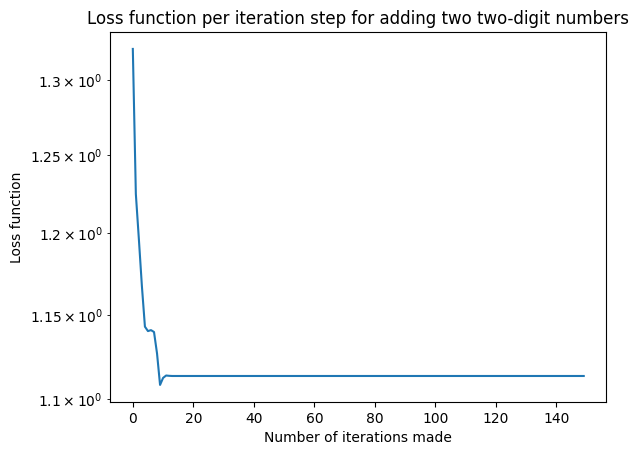

In [25]:
#Create all addition problems for two digit numbers
x_test_add, y_test_add = generateAllAddition()

#Generate the prediction from the neural network
for i in range(length):
    z = np.argmax(network_add.forward(onehot(x_test_add,m)), axis = 1)
    x_test_add = np.append(x_test_add, z[:,-1:], axis = 1)

#Check how many where correct
t = 0
useful_x_values = np.flip(x_test_add[:,-length:], axis = 1)

for idx in range(np.shape(x_test_add)[0]):
    if np.array_equal(useful_x_values[idx], y_test_add[idx]):
        t += 1

#Print the percentage and plot the error function
print("Percentage of valid additions: ", t/(np.shape(x_test_add)[0])*100, "%")

fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
ax.set_yscale('log')
ax.set_title(f'Loss function per iteration step for adding two two-digit numbers')
ax.set_xlabel('Number of iterations made')
ax.set_ylabel('Loss function')
plt.show()